In [ ]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from keras import layers
from keras.applications.densenet import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools




In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG
#don't need to run this every time
benign_train = np.array(Dataset_loader('drive/MyDrive/data/benign/train',224))
malign_train = np.array(Dataset_loader('drive/MyDrive/data/malignant/train',224))
benign_test = np.array(Dataset_loader('drive/MyDrive/data/benign/test',224))
malign_test = np.array(Dataset_loader('drive/MyDrive/data/malignant/test',224))


100%|██████████| 141/141 [01:08<00:00,  2.06it/s]


In [ ]:
#save these numpy files for quicker loading later
np.save('drive/MyDrive/data/begnign_train', benign_train)
np.save('drive/MyDrive/data/begnign_test', benign_test)
np.save('drive/MyDrive/data/malign_train', malign_train)
np.save('drive/MyDrive/data/malign_test', malign_test)

In [ ]:
#code to reload the arrays if runtime is disconnected
benign_train = np.load('drive/MyDrive/data/begnign_train.npy')
benign_test = np.load('drive/MyDrive/data/begnign_test.npy')
malign_train = np.load('drive/MyDrive/data/malign_train.npy')
malign_test = np.load('drive/MyDrive/data/malign_test.npy')

In [ ]:
#label vectors 
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

#shuffle our data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)




In [ ]:
#RUN ONE TIME FOR ALL EXPERIMENTS
#split the training data into train and validation data, 80-20 split
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

#split data into no arrays to store to drive
x_train_np = np.asarray(x_train)
y_train_np = np.asarray(y_train)
x_val_np = np.asarray(x_val)
y_val_np = np.asarray(y_val)

#save the split data so it doesn't shuffle between experiments
np.save('drive/MyDrive/data/x_train', x_train_np)
np.save('drive/MyDrive/data/y_train', y_train_np)
np.save('drive/MyDrive/data/x_val', x_val_np)
np.save('drive/MyDrive/data/y_val', y_val_np)

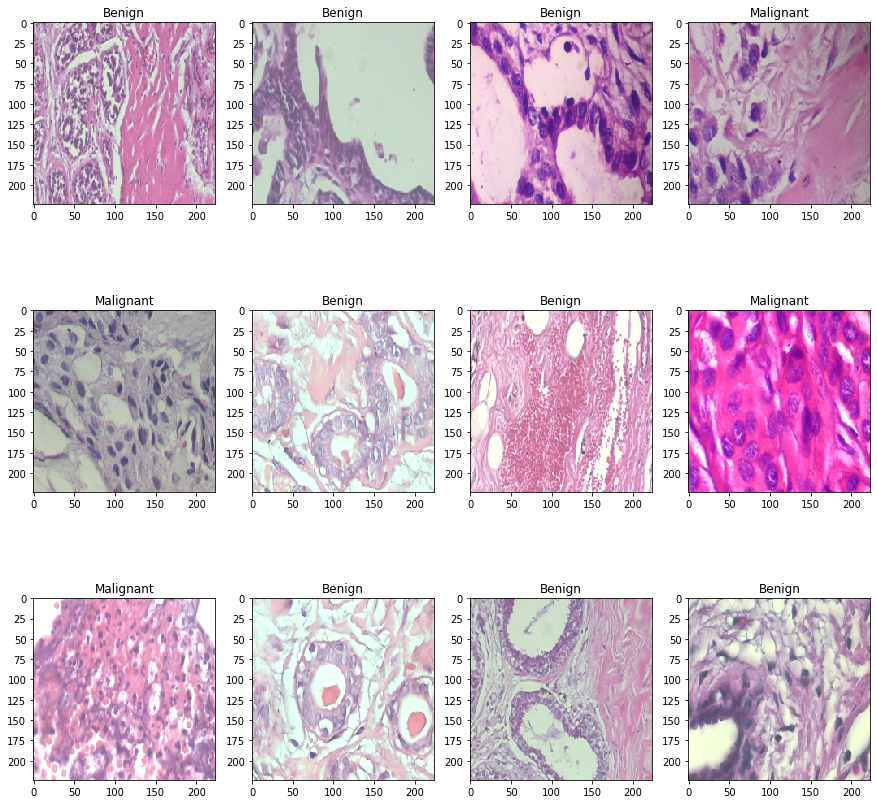

In [ ]:

x_train = np.load('drive/MyDrive/data/x_train.npy')
x_val = np.load('drive/MyDrive/data/x_val.npy')
y_train = np.load('drive/MyDrive/data/y_train.npy')
y_val = np.load('drive/MyDrive/data/y_val.npy')




w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

#plot some examples w labels
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [ ]:
from keras.applications.resnet import ResNet152
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import DenseNet169
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import NASNet
from keras.applications.nasnet import NASNetLarge
from keras.applications.mobilenet import MobileNet



In [ ]:

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    return model


# densenet = DenseNet121(
#     weights = 'imagenet',
#     include_top=False,
#     input_shape=(224,224,3)
# )

densenet = DenseNet201(
    weights = 'imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# resnet = ResNet152(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(224,224,3)
# )

# nasnet = NASNetMobile(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(224,224,3)
# )

# mobilenet = MobileNet(
#     weights = 'imagenet',
#     include_top=False,
#     input_shape=(224,224,3)
# )



# model = build_model(resnet ,lr = 1e-4)
model = build_model(densenet ,lr = 1e-4)
# model = build_model(nasnet ,lr = 1e-4)
# model = build_model(mobilenet ,lr = 1e-4)


model.summary()

74850304/74836368 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
69/69 [==============================] - 686s 9s/step - loss: 0.6324 - accuracy: 0.6572 - val_loss: 0.3499 - val_accuracy: 0.8996

Epoch 00001: val_accuracy improved from -inf to 0.89964, saving model to weights.best.hdf5
Epoch 2/20
69/69 [==============================] - 573s 8s/step - loss: 0.3061 - accuracy: 0.8892 - val_loss: 0.5584 - val_accuracy: 0.8065

Epoch 00002: val_accuracy did not improve from 0.89964
Epoch 3/20
69/69 [==============================] - 568s 8s/step - loss: 0.2701 - accuracy: 0.9042 - val_loss: 0.2525 - val_accuracy: 0.8889

Epoch 00003: val_accuracy did not improve from 0.89964
Epoch 4/20
69/69 [==============================] - 572s 8s/step - loss: 0.2947 - accuracy: 0.8855 - val_loss: 0.1135 - val_accuracy: 0.9606

Epoch 00004: val_accuracy improved from 0.89964 to 0.96057, saving model to weights.best.hdf5
Epoch 5/20
69/69 [==============================] - 572s 8s/step - loss: 0.2369 - accuracy: 0.9089 - val_loss: 0.1070 - val_accuracy: 0.9

[Text(0, 0.5, 'accuracy'), Text(0.5, 0, 'epoch')]

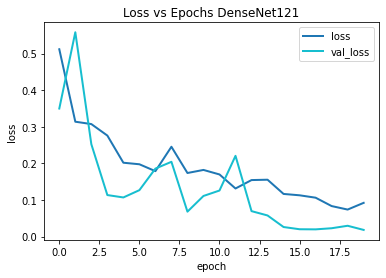

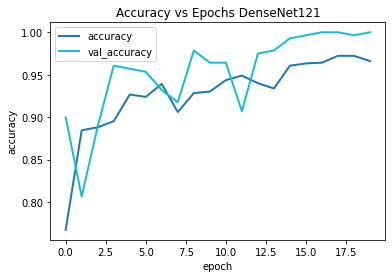

In [ ]:
#plot the loss and accuracy over epochs
history_df = pd.DataFrame(history.history)
ax = history_df[['loss', 'val_loss']].plot(lw=2, colormap='tab10', title='Loss vs Epochs DenseNet121')
ax.set(xlabel="epoch", ylabel="loss")

ax = history_df[['accuracy', 'val_accuracy']].plot(lw=2, colormap='tab10', title='Accuracy vs Epochs DenseNet121')
ax.set(xlabel="epoch", ylabel="accuracy")


Confusion matrix, without normalization
[[ 85   1]
 [  2 139]]


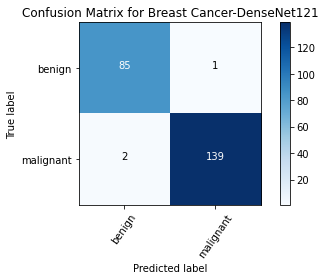

In [ ]:
  Y_pred = model.predict(X_test)



from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for Breast Cancer-DenseNet121')

In [ ]:
from sklearn.metrics import classification_report
cr = classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1), output_dict=True)

df = pd.DataFrame(cr)
print(df)

                   0           1  accuracy   macro avg  weighted avg
precision   0.977011    0.992857  0.986784    0.984934      0.986854
recall      0.988372    0.985816  0.986784    0.987094      0.986784
f1-score    0.982659    0.989324  0.986784    0.985991      0.986799
support    86.000000  141.000000  0.986784  227.000000    227.000000


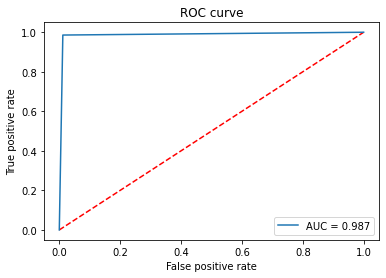

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

**Experiment writeup – 5/5/2021**

Used keras/tensorflow and densenet201 to train a deep CNN to classify tissue images of breast tumors as benign and malignant. Used GPU acceleration and trained for 20 epochs with an ultimate accuracy of .9857 and loss of .0437 on validation data. I need to better understand how to use the test data to truly test the trained model, but I was able to use model.predict to create a confusion matrix which showed promising results. Used sklearn.metrics ROC curve/score and did rather well (AUC = 0.979) fairly strong initial results. 

Precision, recall, and f1 score were as follows:

                    0           1  accuracy   macro avg  weighted avg
precision   0.934783    1.000000  0.973568    0.967391      0.975292
recall      1.000000    0.957447  0.973568    0.978723      0.973568
f1-score    0.966292    0.978261  0.973568    0.972277      0.973726
support    86.000000  141.000000  0.973568  227.000000    227.000000


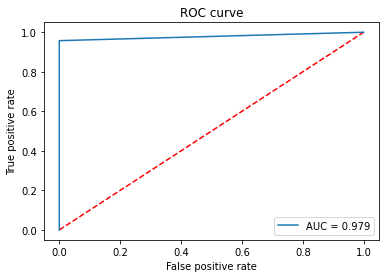

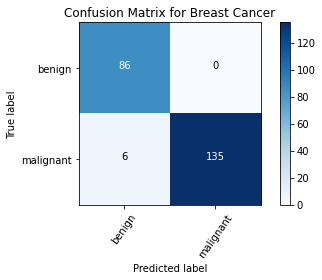

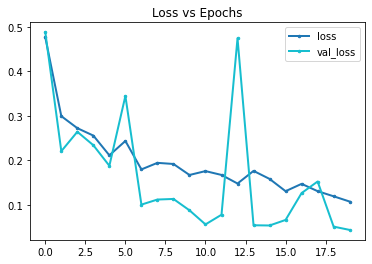

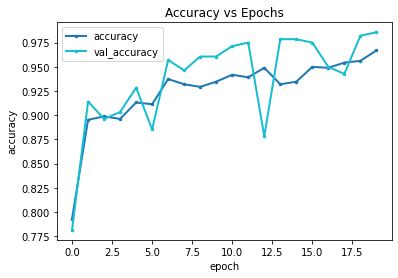

